In [1]:
import pandas as pd 
from deepfake_detection.defaults import TEST_OUT_PATH
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [216]:
path = "/home/faraz/Documents/code/deepfake_detection/experiment_outputs/justify_baseline_b4_lr_0.001__b4/test_two_no_augs.csv"

In [217]:
# test_df = pd.read_csv(TEST_OUT_PATH / test_results_file)
test_df = pd.read_csv(path)

In [218]:
ground_truth = test_df['ground_truth'].to_numpy()
predictions = test_df['predictions'].to_numpy()

In [219]:
ground_truth

array([1., 1., 1., ..., 1., 1., 1.])

In [220]:
predictions

array([0.98858333, 0.98527366, 0.98159987, ..., 0.78683186, 0.55110925,
       0.9280498 ])

In [221]:
def find_precision_threshold(predictions, ground_truth, target_precision=0.99):
    lower_bound = 0
    upper_bound = 1
    precision = 0
    threshold = 0.5 
    
    while lower_bound < upper_bound:
        threshold = (lower_bound + upper_bound) / 2
        thresh_predictions = predictions > threshold
        precision = precision_score(ground_truth, thresh_predictions)

        if precision < target_precision:
            lower_bound = threshold
        else:
            upper_bound = threshold
        
        if upper_bound - lower_bound < 1e-5:
            break

    while precision < target_precision:
        threshold += 1e-5
        thresh_predictions = predictions > threshold
        precision = precision_score(ground_truth, thresh_predictions)
    
    return threshold


import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold_binary_search(predictions, ground_truth, tolerance=1e-5):
    lower_bound = 0.0
    upper_bound = 1.0
    best_threshold = 0.0
    best_f1 = 0.0
    
    while upper_bound - lower_bound > tolerance:
        mid_point = (lower_bound + upper_bound) / 2
        threshold_low = mid_point - tolerance
        threshold_high = mid_point + tolerance

        f1_low = f1_score(ground_truth, predictions > threshold_low)
        f1_mid = f1_score(ground_truth, predictions > mid_point)
        f1_high = f1_score(ground_truth, predictions > threshold_high)
        
        if f1_low > f1_mid:
            upper_bound = mid_point
        elif f1_high > f1_mid:
            lower_bound = mid_point
        else:
            best_f1 = f1_mid
            best_threshold = mid_point
            break

    return best_threshold

# THRESHOLD = find_precision_threshold(predictions, ground_truth)
THRESHOLD = find_best_threshold_binary_search(predictions, ground_truth)
# THRESHOLD = 0.6

In [222]:
thresh_predictions = predictions > THRESHOLD
ground_truth = ground_truth == 1

In [223]:
accuracy = accuracy_score(ground_truth, thresh_predictions)
precision = precision_score(ground_truth, thresh_predictions)
recall = recall_score(ground_truth, thresh_predictions)
f1 = f1_score(ground_truth, thresh_predictions)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")

num_fake = np.sum(ground_truth)
num_real = len(ground_truth) - num_fake
print(f"Count Fake = {num_fake}, Count Real = {num_real}")

Accuracy: 0.6853342667133356, Precision: 0.6326603665521191, Recall: 0.8837883788378837, F1: 0.7374306337881253
Count Fake = 9999, Count Real = 10000


/home/faraz/.cache/pypoetry/virtualenvs/deepfake-detection-luHkh4Hu-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


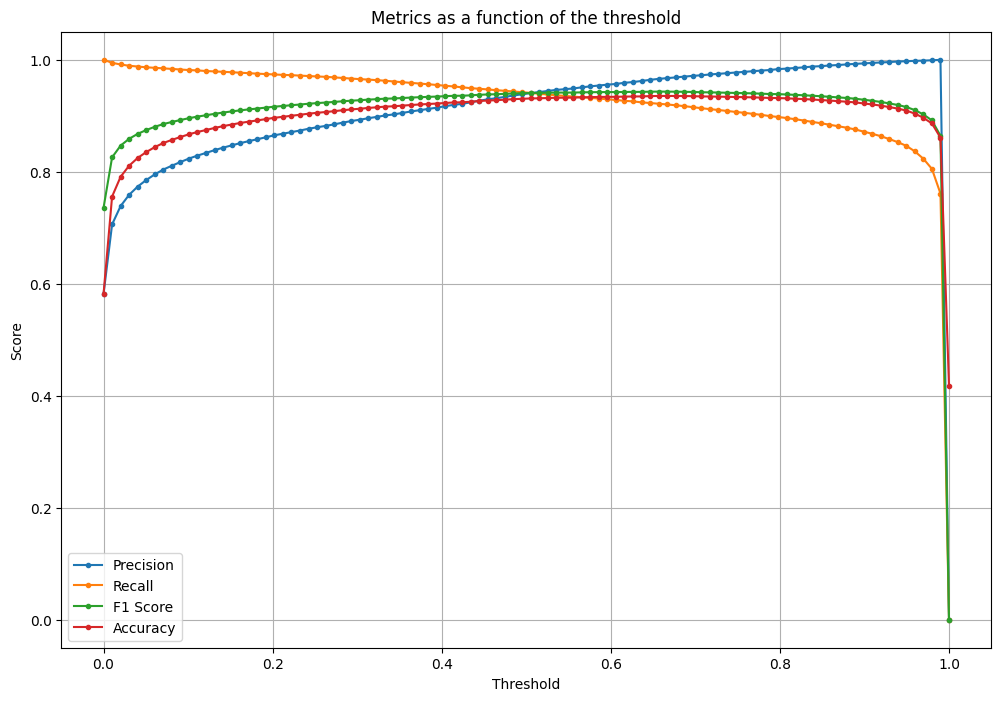

In [215]:
precisions = []
recalls = []
f1_scores = []
accuracies = []

thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    thresh_predictions = predictions > threshold
    accuracy = accuracy_score(ground_truth, thresh_predictions)
    precision = precision_score(ground_truth, thresh_predictions)
    recall = recall_score(ground_truth, thresh_predictions)
    f1 = f1_score(ground_truth, thresh_predictions)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions, label='Precision', marker='.')
plt.plot(thresholds, recalls, label='Recall', marker='.')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='.')
plt.plot(thresholds, accuracies, label='Accuracy', marker='.')
plt.title('Metrics as a function of the threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()